# E91 PROTOCOL

In [17]:
''' 
Create a virtual environment First
Run the follow command to install all library:
    pip install requirements.txt -r
Set up the kernel as the virtual environment
'''

# Import necessary components from Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization.bloch import Bloch

import numpy as np

### Test the libraries are properly working

qiskit version: 2.1.2


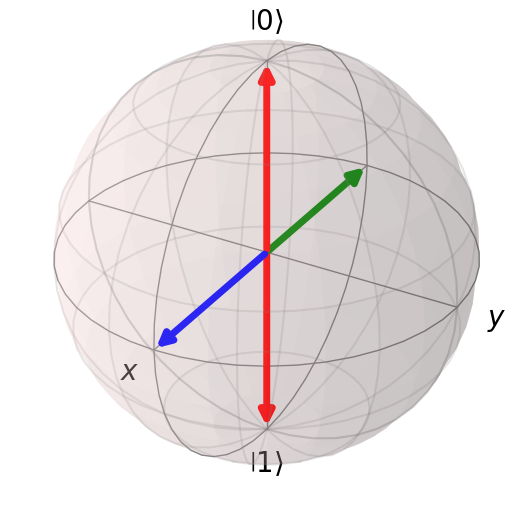

In [18]:
print("qiskit version:", qiskit.__version__)
bloch = Bloch()
bloch.vector_color = ['red', 'red', 'blue', 'green']

sv = []
sv.append([0,0,1])  # |0> in red
sv.append([0,0,-1]) # |1> in red
sv.append([1,0,0])  # |+> in blue
sv.append([-1,0,0]) # |-> in green

bloch.add_vectors(sv)
bloch.render()

In [19]:
# helper.py must be there, its an important file.
from helper import MESSAGE_BITS, EMPTY, SMALL_KEY_LENGTH, MAX_KEY_LENGTH, SIMULATOR_METHOD
from helper import encryption_decryption

#### Resources:
1) [Quantum Key Distribution — E91 protocol](https://medium.com/@askar.b.tony/quantum-key-distribution-e91-protocol-3eba945014cd)
2) [fundamentals of OKD](https://medium.com/@qcgiitr/fundamentals-of-quantum-key-distribution-bb84-b92-e91-protocols-e1373b683ead)

E91
- Entanglement guarantees strong correlations between Alice and Bob.
- Bell’s inequality violation proves absence of eavesdropper.
- Eve’s interference breaks entanglement, reducing correlations.

### Mission Objective:
- Implement the E91 Quantum Key Distribution protocol in this Jupyter notebook using Qiskit. 
- Ensure that Agent A and Agent B successfully exchange a secret quantum key.

In [20]:
# We are going to send a binary message
print(f"Message contains: {MESSAGE_BITS}")
print(f"EMPTY value: {EMPTY}")

Message contains: (0, 1)
EMPTY value: -1


#### TASK 1
For E91 protocol both the parties get a streams of entangled qubits, each of which they can choose to measure in one of the three basis randomly.

In [21]:
# Thus we need to generate a key for encryption
key_length = SMALL_KEY_LENGTH // 2  # Length of the key you want to generate

####  TASK 1  ####
# Prepare Entangled States for Alice and Bob

def prepare_Entangled_States(key_length):
    qc = QuantumCircuit(2 * key_length)  # Create a quantum circuit with qubits and classical bits
    for i in range(key_length):
        # Entangle qubits
        qc.h(i)
        qc.cx(i, i + key_length)
    return qc.to_gate(label=f"Entangler_i<->i+{key_length}")

Now that Agent A and Agent B is ready, they need to setup based on random basis.\
Depending on the Basis, the bits are encoded to corresponding states.

- *Basis:* 
- 0 deg -> Z basis
- 120 deg
- 240 deg

*Hint: Use quantum gate transformations for measurement. Ry gate.*

In [22]:
# In the E91 Protocol, We use three basis for the encryption and measurement
POSSIBLE_BASES = [0, 2 * np.pi / 3, 4 * np.pi / 3]  
print(f"Used_bases: {POSSIBLE_BASES}")

# Random Bases Generator
def random_Bases_generator(qc: QuantumCircuit, key_range, user_name:str|None= None):
    n = len(key_range)
    chosen_random_bases = np.random.choice(POSSIBLE_BASES, size= n)

    # Apply the Basis for given ith qubit
    # Will be used for Alice and Bob setup
    for i, basis in zip(key_range, chosen_random_bases):
        ####  Code goes Here  ####
        qc.ry(theta=basis, qubit= i, label= user_name)
    return qc, chosen_random_bases

alice_bases = None
bob_bases = None

Used_bases: [0, 2.0943951023931953, 4.1887902047863905]


The Quantum circuit contains entangled qubits along with corresponding setup of Alice and Bob

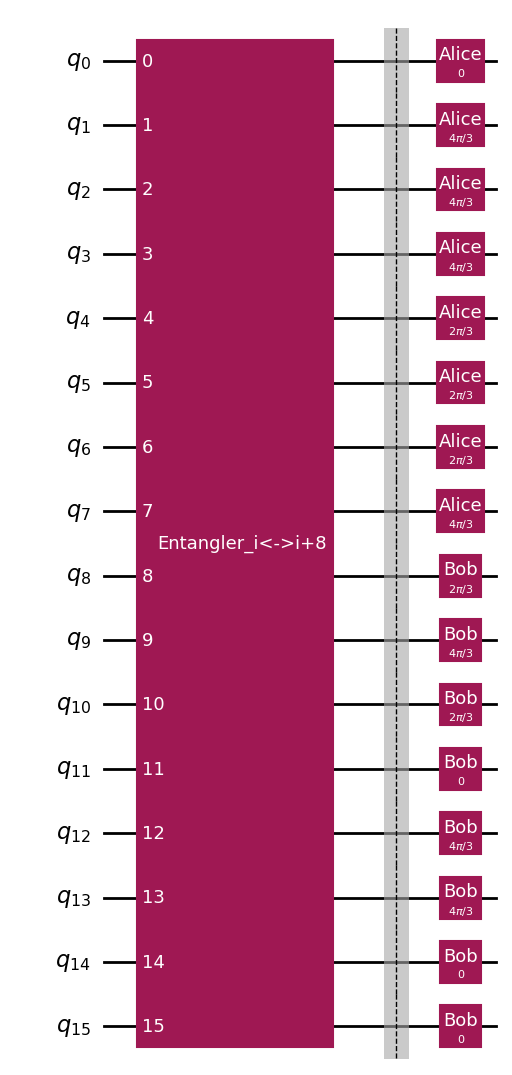

In [23]:
# Prepare Entangled quantum states
qc = QuantumCircuit(SMALL_KEY_LENGTH)
qc.append(prepare_Entangled_States(key_length), range(SMALL_KEY_LENGTH))
qc.barrier()

# Generate Alice's random bases
qc, alice_bases = random_Bases_generator(qc, range(key_length), "Alice")

# Generate Bob's random bases
qc, bob_bases = random_Bases_generator(qc, range(key_length, SMALL_KEY_LENGTH), "Bob")
qc.draw('mpl')

#### TASK 2
We will not measure the qubits, which basically translates to Alice and Bob keeping track of their measured qubits respectively.\
*Physical E91 implementation relies on the fact that qubits arrive time synchronized*, and if any skip takes place, it is noted.\
Here we assume all entangled pairs are properly noted and then measured.

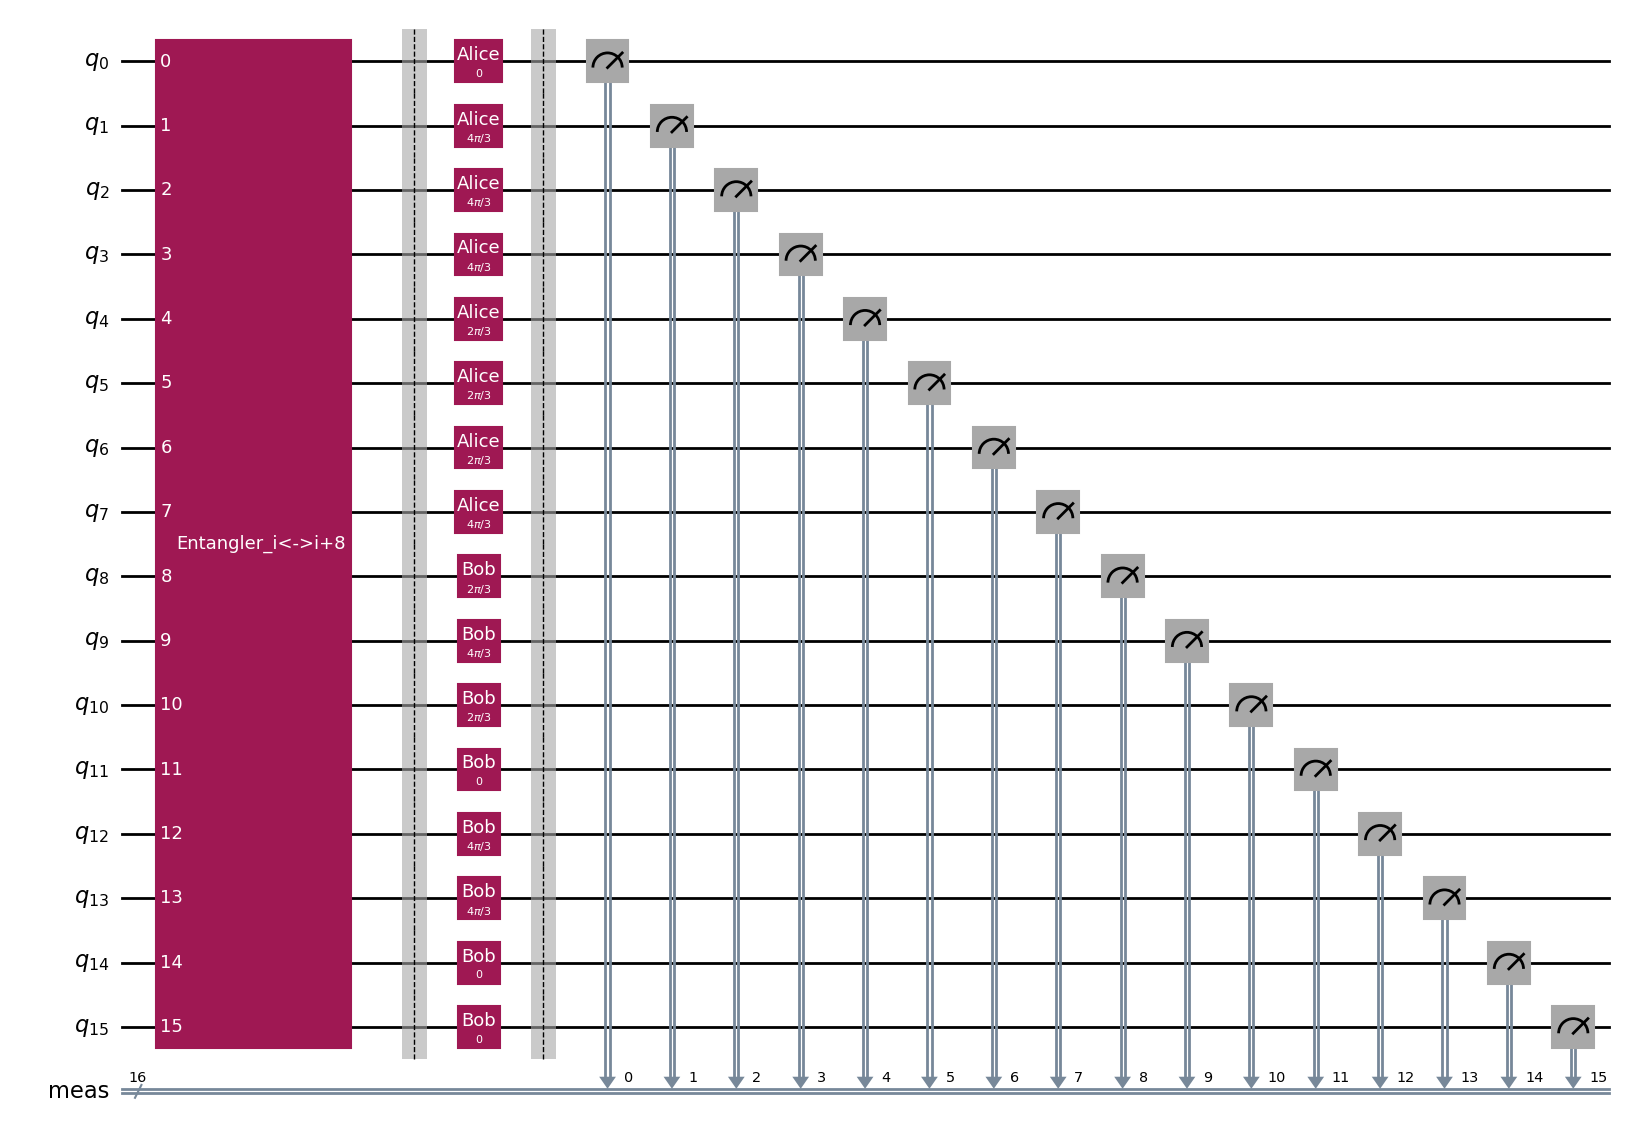

In [24]:
####  TASK 2  ####
# Setup the measurement for all qubits
qc.measure_all()
qc.draw('mpl')

Good, Message received and Measured. Time to get the actual data, Agent.

Measurement results: {'0111001010101110': 1, '1110100010010001': 1, '0111000010001101': 2, '0011101111000111': 2, '0001101011010111': 1, '1011101011000011': 1, '0101100010100101': 1, '1111101000011111': 1, '1000111111110010': 1, '0001111101000011': 1, '0010011111001011': 1, '0110000010001101': 2, '0111100111100101': 1, '0011001101111010': 1, '1000000000010001': 1, '1100011100111010': 1, '0110110010110001': 1, '1001001111101110': 1, '1011111000100011': 1, '1100010100100000': 1, '1011111101000010': 1, '0111000010110101': 1, '0011011111001010': 2, '0101101011100111': 1, '0101011100110111': 1, '1100001010101111': 1, '0100110110110000': 1, '1010100101000100': 1, '0010011001001011': 1, '1011010101001001': 1, '1101100000010101': 1, '1001001101011110': 1, '1101101100100110': 2, '0111110010001001': 1, '0000110111011001': 1, '1011001100011110': 1, '1010111101000010': 1, '1001001101101110': 2, '1010110000100001': 1, '1001100111100101': 1, '1000111111101010': 1, '1111101101100110': 1, '10011000011

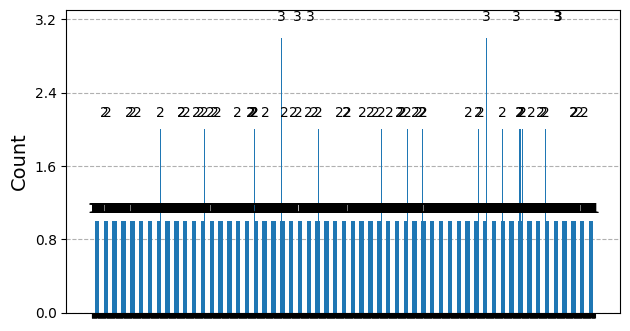

In [25]:
# Simulate the circuit using AerSimulator
def Qsimulator(qc, msg = False):
   # choose one depending on your system or leave default
   simulator = AerSimulator(method= SIMULATOR_METHOD)

   # For execution (This is latest version only qiskit v1.4)
   transpiled_qc = transpile(qc, simulator)  # Transpile the circuit for the simulator
   sim_result = simulator.run(transpiled_qc).result()

   # Agent Bob's measurements simulation
   counts = sim_result.get_counts()
   if(msg):
      print("Measurement results:", counts)
   
   return counts

counts = Qsimulator(qc, True)
# To Check how many key strings generated with frequency
# plot_histogram(counts)

####  Special plot  ####
fig = plot_histogram(counts)
if isinstance(fig, tuple): # handles cases where fig is a tuple (fig, ax)
   ax = fig[1]
else:
   ax = fig.gca()
ax.set_xticklabels([]) # Remove x-axis labels
fig

With the simulations here, you need to pick which key string are you going to choose Agent.\
We leave the choice upto to you. A good choice of key string can mean more matches.

*Hint: You need to pick only one key string.*

In [26]:
####  TASK 3  ####
# Get the only 1 bitstring from the count's keys
def pick_string(counts):
    ####  Code goes Here  ####
    return str(max(counts, key= counts.get))
    pass

# Convert the key string back to bits
key_string = pick_string(counts)
key_bits = [int(bit) for bit in key_string[::-1]]   # qiskit orders q0q1q2...

# Corresponding measurements
Alice_bits = key_bits[:key_length]
Bob_bits = key_bits[key_length:SMALL_KEY_LENGTH]
print(f"Output: Alice:{Alice_bits} Bob:{Bob_bits}")

Output: Alice:[0, 1, 0, 0, 0, 1, 0, 0] Bob:[1, 1, 1, 1, 1, 0, 1, 0]


You have picked a bit string Agent.\
Well, go for the next stage, try to use the E91 protocol and infer from your bases only.\
We are only concerned with places where the basis for measurement of Agent A and Agent B match.

In [27]:
####  TASK 4  ####
# Record the positions where Agent B can say with confidence which bits will be same
bit_positions = [] # put 0 or 1 on the indexes where you can say for guarantee

# Also, store the likely key
unity_index = []

def infer_bits(key_bits, alice_bases, bob_bases, key_length):
    u_index, bit_pos = [], list([EMPTY] * key_length)

    for i, (alice_base, bob_base) in enumerate(zip(alice_bases, bob_bases)):
        ####  Code goes Here  ####
        if(alice_base == bob_base):
            u_index.append(key_bits[i])
            bit_pos[i] = key_bits[i]
        pass
    return u_index, bit_pos

# Infered key bits from measurements
unity_index, bit_positions = infer_bits(key_bits, alice_bases, bob_bases, key_length)
print("Likey key from matched Bases:", unity_index)

Likey key from matched Bases: [1]


In case, *the likely key, comes out to be EMPTY*. Thats because of random choice and quantum noise in simulations.\
Just re-run the file till you get a non-EMPTY key.

In [28]:
# Final keys
# These keys will match a 100% since this is quantum entangled and even in simulation they will be coherent
alice_sifted_key, _ = infer_bits(Alice_bits, alice_bases, bob_bases, key_length)
bob_shifted_key, _ = infer_bits(Bob_bits, bob_bases, alice_bases, key_length)

print("Alice's key:", alice_sifted_key)
print("bob's key:", bob_shifted_key)

Alice's key: [1]
bob's key: [1]


### Mission complete
Well done, Agent. Time for field testing.

### New Mission Objective:
- Help Agent A and Agent B communicate the below message
- Encrypt and Decrypt using the key
- Abort the protocol if Fault tolerance is exceeded

In [29]:
# This Agent Alice's message
important_message = "QuantumKey"

In [30]:
# A message to bits encryption and decryption protocol
# This return None on invalid values and on valid values returns a list of encrypted bits or string after decryption
sample_key = [1,0,1]

# Change the sample key to see the effect on sample bits
sample_bits = encryption_decryption("I am Quantum", sample_key)

print(sample_bits)
print("Decrypted message:", encryption_decryption(sample_bits, sample_key, "decryption"))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decrypted message: I am Quantum


#### TASK 6
Complete the full implementation for the QKD E91.

In [31]:
####  TASK 6  ####
# Use the below functions and make a complete encryption, decryption procedure
key_length = MAX_KEY_LENGTH // 2

# The key loop
def generate_key_pair(trials):
    global alice_sifted_key, bob_sifted_key, t
    alice_sifted_key, bob_sifted_key, t = [0], [1], 0

    while(alice_sifted_key != bob_sifted_key and t < trials):
        # Generate the random bits for the key.

        ####  Code goes Here  ####
        qc = QuantumCircuit(MAX_KEY_LENGTH)
        qc.append(prepare_Entangled_States(key_length), range(MAX_KEY_LENGTH))

        # Generate Alice's random bases
        qc, alice_bases = random_Bases_generator(qc, range(key_length))

        # Generate Bob's random bases
        qc, bob_bases = random_Bases_generator(qc, range(key_length, MAX_KEY_LENGTH))

        # Add measurements to the circuit
        qc.measure_all()

        # Hand over the states for measurement
        counts = Qsimulator(qc)

        ####  Code goes Here  ####
        key_string = pick_string(counts)
        key_bits = [int(bit) for bit in key_string[::-1]]   # qiskit orders q0q1q2...

        ####  Code goes Here  ####
        Alice_bits= key_bits[:key_length]
        Bob_bits = key_bits[key_length:MAX_KEY_LENGTH]

        alice_sifted_key, _ = infer_bits(Alice_bits, alice_bases, bob_bases, key_length)
        bob_sifted_key, _ = infer_bits(Bob_bits, bob_bases, alice_bases, key_length)

        # Minimum key length we want to establish
        KEY_THRESHOLD = 8
        if(len(alice_sifted_key) < KEY_THRESHOLD):
            print("Key too small to compare.")
            alice_sifted_key = [0]
            bob_shifted_key = [1]
        t += 1

# Number of trials to make for making key pair
trials = 10
generate_key_pair(trials= trials)
print(f"Trials taken to generate key: {t} / {trials}")
print("Alice key", alice_sifted_key)
print("Bob key", bob_sifted_key)

Trials taken to generate key: 1 / 10
Alice key [0, 0, 0, 0, 0, 0, 1, 0]
Bob key [0, 0, 0, 0, 0, 0, 1, 0]


Here Alice encodes with her key\
And Bob decodes with the inverse key

- Other implementations use anti-correlated keys also.

In [32]:
# For message transmission
print("Alice sent:", important_message)

# Alice encrypts using her key
encrypted_message = encryption_decryption(important_message, alice_sifted_key)

print("Encrypted binary message:", encrypted_message)

# Hand over the message over public communication
# Bob decrypts using his key
decrypted_message = encryption_decryption(encrypted_message, bob_sifted_key, "decryption")
print("Bob reads:", decrypted_message)

Alice sent: QuantumKey
Encrypted binary message: [0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]
Bob reads: QuantumKey


#### *For any doubts feel free to contact me.*
- Notebook by Anshurup gupta\
[email: anshurup.gupta@gmail.com](mailto:anshurup.gupta@gmail.com)